# Designing BaseDocumentStore
* llama-index
    * https://github.com/run-llama/llama_index/blob/7391f302e18542c68b9cf5025afb510af4a52324/llama-index-core/llama_index/core/storage/docstore/types.py#L24

In [1]:
import json
from pathlib import Path
import os
import time

import pandas as pd
from tqdm import tqdm

from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(
        env_file="../.env", env_file_encoding="utf-8", extra="ignore"
    )
    data_dir: str
    model_dir: str
    docling_model_dir: str
    
settings = Settings()
os.environ["HF_HOME"] = settings.docling_model_dir

In [2]:
import sys
sys.path.append("src")

from core.reader import PDF2ImageReader
from core.embedder import LocalColpaliEngineEmbedder
from core.storage.docstore import InMemoryDocumentStore

# 1. Read Documents

In [3]:
# testing on macOS
poppler_path = "/opt/homebrew/Cellar/poppler/25.01.0/bin"
reader = PDF2ImageReader(poppler_path=poppler_path)

In [4]:
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

In [12]:
documents = []

for fname in tqdm(pdf_fnames[:3]):
    file_path = os.path.join(pdf_dir, pdf_fnames[0])
    document = reader.run(file_path)
    document.nodes = document.nodes[:10] ## test with only first 10 pages
    documents.append(document)

100%|██████████| 3/3 [00:26<00:00,  8.86s/it]


# 2. Store Documents

In [13]:
docstore = InMemoryDocumentStore()

In [14]:
docstore.add(documents)

['81e75b48-7806-4d58-9218-79d0630ef0c3', '4d4e15f1-15ab-41db-8403-f2c8655cf6f2', '30fb1bd6-0279-4a00-9003-41a620b1f68f']


In [15]:
docstore.count()

3

In [17]:
docstore.save('temp/docstore_test.json')

In [18]:
docstore.drop()
docstore.load('temp/docstore_test.json')

In [22]:
print(docstore.count())
document = docstore.get('81e75b48-7806-4d58-9218-79d0630ef0c3')[0]

3


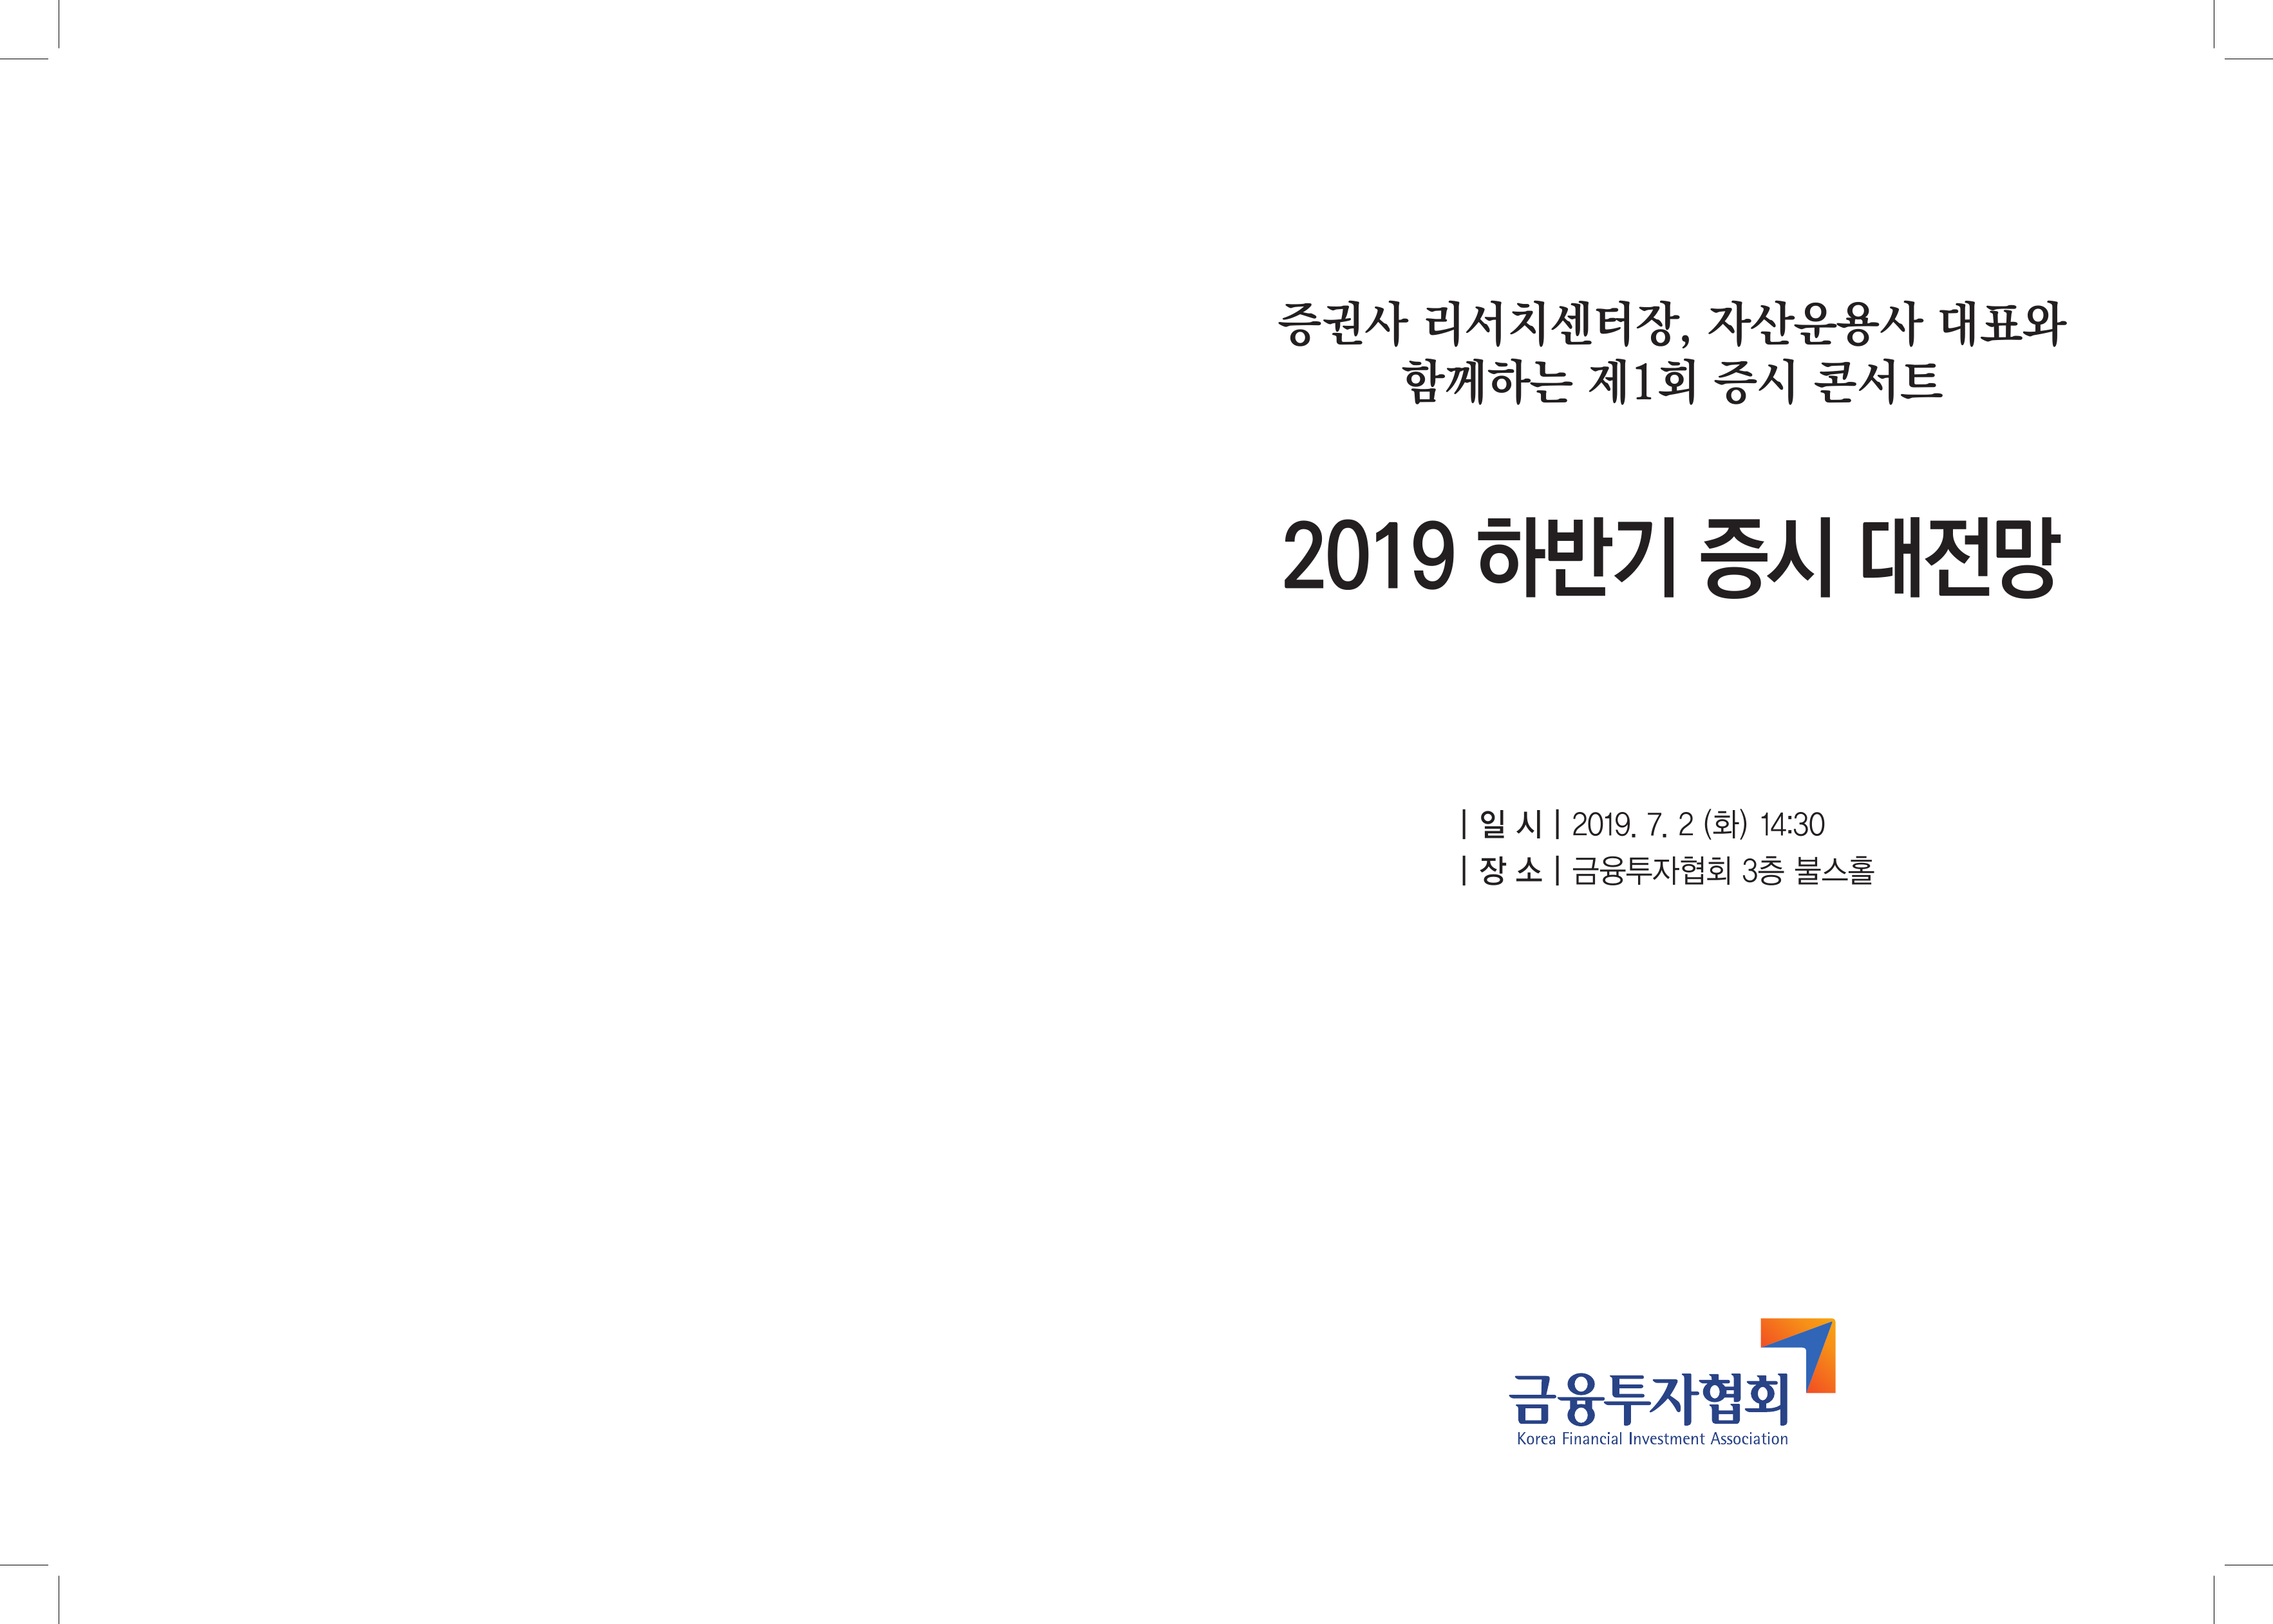

In [23]:
document.nodes[0].image